# Machine Learning - Recommender System

---

#### **Load  Data & libraries**

In [14]:
import dtale
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import iplot, init_notebook_mode

from pyproj import CRS, Transformer
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler

In [15]:
data = pd.read_csv('../Divar Dataset/Divar.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)

/var/folders/9y/lpsdwq1d0bz2t5178sr1rgmr0000gn/T/ipykernel_95066/1300283319.py:1: DtypeWarning:

Columns (11,27,29,53) have mixed types. Specify dtype option on import or set low_memory=False.



In [16]:
# # d-tale
# d = dtale.show(data)
# d.open_browser()

## **Part 1** <br>
↪ Clustering Data Using K-Means Algorithm with 10 Clusters

### **Preprocessing & Finding Best Feature Set**

First we will try `K-means` on  4 different feature sets namely: `feature_set_[1,2,3]` to find a better clustering feature set.<br>
To achieve the best set, we then evaluate our clustering model with the following `Evaluation Metric`:<br>

* `davies_bouldin_score`

Finally, we choose the `best feature set` to plot on Iran's map and show the clustering data comprehensively

In [65]:
# Intuitive feature selection for K-means
feature_set_1 = data[['location_latitude', 'location_longitude', 'price_value']]
feature_set_2 = data[['location_latitude', 'location_longitude', 'price_value', 'building_size', 'construction_year']]
feature_set_3 = data[['location_latitude', 'location_longitude', 'price_value', 'rent_value', 'credit_value']]

Preprocess Feature Set 1:

In [66]:
# Handling missing values
feature_set_1 = feature_set_1.dropna()

# Outlier Handling
pf = PowerTransformer(method='yeo-johnson')
feature_set_1['price_value'] = pf.fit_transform(feature_set_1[['price_value']])

# Feature Scaling
scaler = StandardScaler()
feature_set_1_scaled = scaler.fit_transform(feature_set_1)
feature_set_1_scaled = pd.DataFrame(feature_set_1_scaled, columns=feature_set_1.columns)

Preprocess Feature Set 2:

In [67]:
# Handling missing values
feature_set_2 = feature_set_2.dropna()

# Digits conversion to english
def persian_to_english(sample_input: str):
    persian_digits = '۰۱۲۳۴۵۶۷۸۹'
    english_digits = '0123456789'
    trans_table = str.maketrans(persian_digits, english_digits)
    return sample_input.translate(trans_table)

feature_set_2['construction_year'] = feature_set_2.loc[:, 'construction_year'].apply(
    lambda x: persian_to_english(x) if isinstance(x, str) else x)

# change to only digits
feature_set_2['construction_year'] = feature_set_2['construction_year'].replace('قبل از 1370', '1370')
# change to numeric type
feature_set_2['construction_year'] = pd.to_numeric(feature_set_2['construction_year'], errors='coerce')
feature_set_2['age'] = 1404 - feature_set_2['construction_year']
feature_set_2.drop(columns=['construction_year'], inplace=True)

# Outlier Handling
pf = PowerTransformer(method='yeo-johnson')
feature_set_2['price_value'] = pf.fit_transform(feature_set_2[['price_value']])
feature_set_2['building_size'] = pf.fit_transform(feature_set_2[['building_size']])

# Feature Scaling
scaler = StandardScaler()
feature_set_2_scaled = scaler.fit_transform(feature_set_2)
feature_set_2_scaled = pd.DataFrame(feature_set_2_scaled, columns=feature_set_2.columns)

Preprocess Feature Set 3:

In [68]:
# Fill price_value missing values with transformed_price based on rent_value and credit_value
def rent_to_price(rent, credit):
    """
    Convert rent to price
    """
    if rent < 0 or credit < 0:
        return 0
    credit_total = credit + (rent * 100) / 3
    transformed_price = credit_total * 6
    return max(0, transformed_price)

# Transform price value
feature_set_3.loc[:, 'price_value'] = feature_set_3.apply(
    lambda row: rent_to_price(row['rent_value'], row['credit_value']) if
      (pd.isna(row['price_value']) & pd.notna(row['rent_value']) & pd.notna(row['credit_value'])) else row['price_value'],
       axis=1)

# Drop unnessary features
feature_set_3 = feature_set_3.drop(columns=['rent_value', 'credit_value'], axis=1)

# Handling missing values
feature_set_3 = feature_set_3.dropna()

# Outlier Handling
feature_set_3_cp = feature_set_3.copy()
pf = PowerTransformer(method='yeo-johnson')
feature_set_3_cp['price_value'] = pf.fit_transform(feature_set_3_cp[['price_value']])

# Feature Scaling
scaler = StandardScaler()
feature_set_3_scaled = scaler.fit_transform(feature_set_3_cp)
feature_set_3_scaled = pd.DataFrame(feature_set_3_scaled, columns=feature_set_3_cp.columns)

#### Evaluation 
We use `k-means` with `n_cluster=10` for the feature sets. <br>
Then we evaluate the trained models with <b> Davis Bouldin metric</b>.

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import (
    davies_bouldin_score,
    calinski_harabasz_score,
    silhouette_score
)
import pandas as pd

k_values = 10

features_dict = {
    'Feature Set 1': feature_set_1_scaled,
    'Feature Set 2': feature_set_2_scaled,
    'Feature Set 3': feature_set_3_scaled,
}

results_dict = {}

for feature_name, feature_data in features_dict.items():
    kmeans = KMeans(
        n_clusters=k_values,
        random_state=42,
        n_init=10
    )
    
    cluster_labels = kmeans.fit_predict(feature_data)

    results_dict[feature_name] = {
        'Davies-Bouldin': davies_bouldin_score(feature_data, cluster_labels),
        'Calinski-Harabasz': calinski_harabasz_score(feature_data, cluster_labels),
        'Silhouette': silhouette_score(
            feature_data,
            cluster_labels,
            sample_size=10000,
            metric="euclidean"
        ),
        'Inertia': kmeans.inertia_,
        'cluster_labels': cluster_labels,
        'kmeans': kmeans,
    }
    
    scores_only = [
    {
        'Feature Set': key,
        'Davies-Bouldin Score': value['Davies-Bouldin'],
        'Calinski-Harabasz': value['Calinski-Harabasz'],
        'Silhouette': value['Silhouette'],
        'Inertia': value['Inertia'],
    }
    for key, value in results_dict.items()
]

results_df = pd.DataFrame(scores_only)
print(results_df)

     Feature Set  Davies-Bouldin Score  Calinski-Harabasz  Silhouette  \
0  Feature Set 1              0.878967      165152.508478    0.342473   
1  Feature Set 2              1.149445       54498.113879    0.248324   
2  Feature Set 3              0.801962      279838.708899    0.376349   

         Inertia  
0  223523.122075  
1  571894.037482  
2  353549.800054  


Plot feature sets scatter on map with cluster centers:

In [ ]:
# Plot the 3 Feature sets scatter on map with cluster centers
from sklearn.cluster import KMeans

fig = make_subplots(rows=2, cols=2, subplot_titles=list(features_dict.keys()) ,row_heights=[0.5, 0.5])

for i, (feature_name, result) in enumerate(results_dict.items()):
    row = i // 2 + 1
    col = i % 2 + 1
    feature_data = features_dict[feature_name]
    cluster_labels = result['cluster_labels']
    kmeans = result['kmeans']
    
    fig.add_trace(
        go.Scattergl(
            x=feature_data['location_longitude'],
            y=feature_data['location_latitude'],
            mode='markers',
            marker=dict(
                color=cluster_labels,
                colorscale='Viridis',
                showscale=True,
                size=5,
                opacity=0.7
            ),
            name='Data Points',
            showlegend=False
        ),
        row=row,
        col=col
    )
    
    centers = kmeans.cluster_centers_
    centers_lat = centers[:, 1] 
    centers_lon = centers[:, 0]
    
    fig.add_trace(
        go.Scattergl(
            x=centers_lon,
            y=centers_lat,
            mode='markers',
            marker=dict(
                color='red',
                size=10,
                symbol='x'
            ),
            name='Centroids',
            showlegend=False
        ),
        row=row,
        col=col
    )

fig.update_layout(
    width=1000,
    height=800,
    showlegend=False
)

fig.show()


According to the results, for **feature set 3**:
- `Davis Bouldin` is the lowest for this feature set
- `Silhoutte Score` is the highest
- `Calinski-Harabasz` is also highest
So this feature set is the best chioce among the chosen sets.<br>

You can also see from the maps that this feature set has more dense and reasonable clusters, with most centroids located in Iran's borders.

#### Best Feature set: `feature_set_3`:<br>
**↪ Features to select:** `location_latitude`, `location_longitude`, `price_value`, `rent_value`, `credit_value`

In [35]:
# Delete unnessary variables
del feature_set_1, feature_set_1_scaled, feature_set_2, feature_set_2_scaled
del cluster_labels, fig
del feature_data, feature_name, features_dict, feature_set_3_cp, feature_set_3_scaled, kmeans

#### Work on Chosen Feature Set

Remove data points out of **Iran's borders** using **GeoPandas**:

In [69]:
# Get only datapoints within Iran's borders
import geopandas as gpd

# Build GeoDataFrame in WGS84
gdf = gpd.GeoDataFrame(
    feature_set_3,
    geometry=gpd.points_from_xy(
        feature_set_3["location_longitude"],
        feature_set_3["location_latitude"]
    ),
    crs="EPSG:4326"
)

# Load Iran border (Natural Earth)
iran = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
)
iran = iran[iran["NAME"] == "Iran"].to_crs("EPSG:4326")

# Spatial filter
iran_geom = iran.geometry.iloc[0]
gdf = gdf[gdf.within(iran_geom)].copy()


Convert geographical coordinates to UTM format:

In [70]:
# Find and add Iran's UTM zones
gdf['utm_zone'] = (np.floor((gdf['location_longitude'] + 180) / 6) + 1).astype(int)
print("Zones are: ", gdf['utm_zone'].unique())

Zones are:  [39 40 38 41]


In [71]:
# Adding UTM cordinations to the data points
def apply_utm_conversion(group):
    zone = group.name
    wgs84_crs = CRS.from_epsg(4326)
    utm_crs = CRS.from_epsg(32600 + zone)
    transformer = Transformer.from_crs(wgs84_crs, utm_crs, always_xy=True)
    
    easting, northing = transformer.transform(
        group['location_longitude'].values,
        group['location_latitude'].values
    )
    
    group['utm_easting'] = easting
    group['utm_northing'] = northing
    return group

gdf = gdf.groupby(['utm_zone'], group_keys=False).apply(apply_utm_conversion, include_groups=False)
gdf.head()

location_latitude  location_longitude   price_value  \
2           35.703865           51.373459  9.700000e+09   
7           35.729832           51.505466  8.700000e+09   
8           35.712364           50.794781  6.500000e+08   
10          35.778664           51.757549  2.600000e+09   
11          35.733952           51.380608  7.200000e+09   

                     geometry    utm_easting  utm_northing  
2   POINT (51.37346 35.70387)  533784.424602  3.951168e+06  
7   POINT (51.50547 35.72983)  545711.558185  3.954101e+06  
8   POINT (50.79478 35.71236)  481437.130969  3.952066e+06  
10  POINT (51.75755 35.77866)  568467.028494  3.959664e+06  
11  POINT (51.38061 35.73395)  534418.187237  3.954507e+06

#### **Outlier Handling**

See variables distributions:

In [ ]:
gdf.hist(figsize=(10, 8), bins=30, edgecolor='black')

Remove Noise:

In [73]:
# Remove rows where price_value is 0
gdf = gdf[gdf['price_value'] != 0]

In [74]:
# Create a copy of the dataframe to test on both power transformer and log
gdf_pt = gdf.copy()
gdf_log = gdf.copy()

##### **First option:** Apply Power Transformers:

In [75]:
# Import yea_johnson power transformer
from sklearn.preprocessing import PowerTransformer

# Initialize the transformer
pt = PowerTransformer(method='yeo-johnson')
# Apply the transformation  
gdf_pt['price_value'] = pt.fit_transform(gdf_pt[['price_value']])

#### **Feature Scaling**

Feature Scaling to have better clustering using K-means.

In [76]:
# Feature Scaling on the Features : utm_easting , utm_northing, price_value
scalar = StandardScaler()
gdf_pt_scaled = scalar.fit_transform(gdf_pt[['location_latitude', 'location_longitude', 'price_value']])
gdf_pt_scaled = pd.DataFrame(gdf_pt_scaled, columns=['location_latitude', 'location_longitude', 'price_value'])

### **Train K-Means Model for Clustering**<br>

In [77]:
from sklearn.cluster import KMeans

# Train the model
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(gdf_pt_scaled)
gdf_pt['cluster_number'] = cluster_labels

# Find the original cluster centers
centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)

# location_latitude, location_longitude of centroids
centers_lat = centers_original[:, 0]  
centers_lon = centers_original[:, 1] 

# inverse transform price_value
gdf_pt['price_value'] = pf.inverse_transform(gdf_pt[['price_value']])

#### **Plot The Map**

In [109]:
# Plot the Map

# Force cluster_number to be categorical by converting it to string
gdf_pt["cluster_number"] = gdf_pt["cluster_number"].astype(str)

# Define a cluster color palette
cluster_colors = {
    0: "#264653",  # deep blue-gray
    1: "#2A9D8F",  # dark teal
    2: "#1B4332",  # dark green
    3: "#9B2226",  # dark red
    4: "#5A189A",  # deep purple
    5: "#7F5539",  # dark brown
    6: "#C9184A",  # dark magenta
    7: "#495057",  # charcoal gray
    8: "#B08900",  # dark mustard
    9: "#005F73",  # dark cyan
}

fig = px.scatter_map(
    gdf_pt, 
    lat='location_latitude', 
    lon='location_longitude', 
    color='cluster_number',
    color_discrete_map=cluster_colors,
    hover_data=['price_value', 'utm_easting', 'utm_northing'],
    map_style="open-street-map",
    zoom=3.75, 
    center={"lat": 32.4279, "lon": 53.6880},
    title='Geographical Scatter Plot of samples with K-means Clusters (10 Clusters) - Yeo-Johnson Power Transformer',
    width=1550,
    height=800,
)

# Add Cluster Centers
fig.add_trace(
    go.Scattermap(
        lat=centers_lat,
        lon=centers_lon,
        mode='markers+text',
        marker=dict(size=15, color='red', symbol='star', ),
        text=[f'Cluster {i}' for i in range(len(centers_lat))],
        textposition="top center",
        textfont=dict(size=12),
        hovertemplate='<b>Cluster %{text}</b><br>Lat: %{lat}<br>Lon: %{lon}<extra></extra>'
    )
)

fig.show()

##### **Second option:** Apply Log Transformation:

In [79]:
# Apply log transformation
gdf_log['price_value'] = np.log(gdf_log['price_value'])

#### **Feature Scaling**

Feature Scaling to have better clustering using K-means.

In [80]:
# Feature Scaling on the Features : utm_easting , utm_northing, price_value
scalar = StandardScaler()
gdf_log_scaled = scalar.fit_transform(gdf_log[['location_latitude', 'location_longitude', 'price_value']])
gdf_log_scaled = pd.DataFrame(gdf_log_scaled, columns=['location_latitude', 'location_longitude', 'price_value'])

### **Train K-Means Model for Clustering**<br>

In [81]:
from sklearn.cluster import KMeans

# Train the model
kmeans = KMeans(n_clusters=10, random_state=42)
cluster_labels = kmeans.fit_predict(gdf_log_scaled)
gdf_log['cluster_number'] = cluster_labels

# Find the original cluster centers
centers_scaled = kmeans.cluster_centers_
centers_original = scaler.inverse_transform(centers_scaled)

# location_latitude, location_longitude of centroids
centers_lat = centers_original[:, 0]  
centers_lon = centers_original[:, 1] 

# inverse transform price_value
gdf_log['price_value'] = pf.inverse_transform(gdf_log[['price_value']])

#### **Plot The Map**

In [ ]:
# Plot the Map

# Force cluster_number to be categorical by converting it to string
gdf_log["cluster_number"] = gdf_log["cluster_number"].astype(str)

# Define a cluster color palette
cluster_colors = {
    0: "#264653",  # deep blue-gray
    1: "#2A9D8F",  # dark teal
    2: "#1B4332",  # dark green
    3: "#9B2226",  # dark red
    4: "#5A189A",  # deep purple
    5: "#7F5539",  # dark brown
    6: "#C9184A",  # dark magenta
    7: "#495057",  # charcoal gray
    8: "#B08900",  # dark mustard
    9: "#005F73",  # dark cyan
}

fig = px.scatter_map(
    gdf_log, 
    lat='location_latitude', 
    lon='location_longitude', 
    color='cluster_number',
    color_discrete_map=cluster_colors,
    hover_data=['price_value', 'utm_easting', 'utm_northing'],
    map_style="open-street-map",
    zoom=3.75, 
    center={"lat": 32.4279, "lon": 53.6880},
    title='Geographical Scatter Plot of samples with K-means Clusters (10 Clusters) - Log Transformation',
    width=1550,
    height=800,
)

# Add Cluster Centers
fig.add_trace(
    go.Scattermap(
        lat=centers_lat,
        lon=centers_lon,
        mode='markers+text',
        marker=dict(size=15, color='red', symbol='star', ),
        text=[f'Cluster {i}' for i in range(len(centers_lat))],
        textposition="top center",
        textfont=dict(size=12),
        hovertemplate='<b>Cluster %{text}</b><br>Lat: %{lat}<br>Lon: %{lon}<extra></extra>'
    )
)

fig.show()

#### **↪ Analysis**:
Both maps done by Yeo-Johnson transformer & log transformation look so much simillar, so we do a general analysis on them (specifically on first one).<br>

According to the map, it is obviou that thera are meaningfull clusters that each one cover a region: <br>
- One cluster (Cluster 0) covers most properties from **Northern-Center** (*Tehran*, *Alborz*, *Ghom*, *Semnan*, *Ghazvin*) and **North** of Iran (*Mazandaran*, *Gilan*, *Golestan*).

- One Cluster (Cluster 4) covers most properties from **Northern-West** (*East** &* *West* *Azarbaijan*, *Kurdestan*, *Ardebil*, *Zanjan*) of Iran.

- One cluster (Cluster 9) covers most properties from **West** (Lorestan, Markazi, Hamedan, Kermanshah, Ilam) of Iran.

- One cluster (Cluster 1) covers most properties from **Northern-East** (*Khorasan*, a part of *Golestan*) from Iran.

- One cluster (Cluster 5) covers most properties from **South** and **South-East** of Iran (*Hormozgan*, *Kerman*, *Sistan* & *Baluchestan*, parts of *Fars*).

- One Cluster (Cluster 2) covers most properties from **South West** (*Khozestan*, *Bushehr*, *Isfahan*, *Chaharmahal*, *Kohgiluye*) of Iran.
<br><br>

⚠️ When you look closly, you'll see some regions contain multiple clusters. One conclusion from this can be the diversity of prices between different neighborhood or **Class Difference** in the region.<br><br>
↪ As an example, in **Tehran** there are some properties located in the northern area of the city that belongs to another cluster (cluster 3).<br>
↪ Also in **North** of Iran, properties near the **Caspian see** are from a different cluster.

In [83]:
del fig, cluster_colors

---

## **Part 2** <br>
Find the best **K** for clustering by leveraging multiple methods.

#### **Find Best K for Power Transformed Data**

#### **#1 Method:**  Elbow method (with WSS, also called Inertia)

**Lower** value of WSS indicates better clustering.

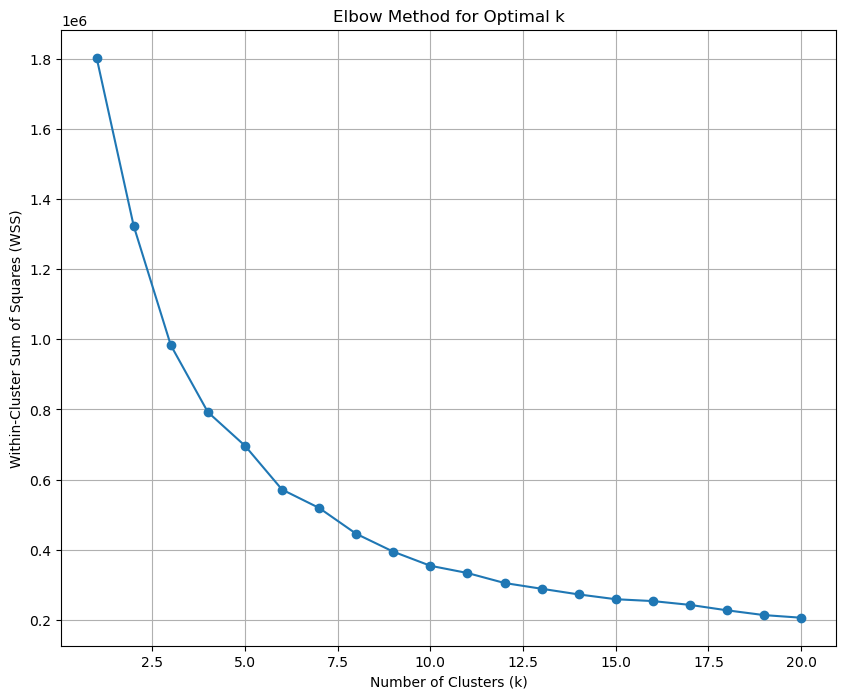

In [ ]:
# Defne range of k values
k_range = range(1, 21)

# Compute inertia (WSS) for each k
wss = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(gdf_pt_scaled)
    wss.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 8))
plt.plot(k_range, wss, marker='o')  # Plot k vs. WSS with markers
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.grid(True)
plt.show()

➡️ From the plot, it seems `7` or `10` might be the optimal value for **K** (number of clusters). 

☑️ For more ensurance, we also plot the **Silhouette Score**, **Davies-Bouldin Index**, and **Calinski-Harabasz Index**.

#### **#2 Method:** Silhouette Score

The **higher** it is, the more separated the clusters are.

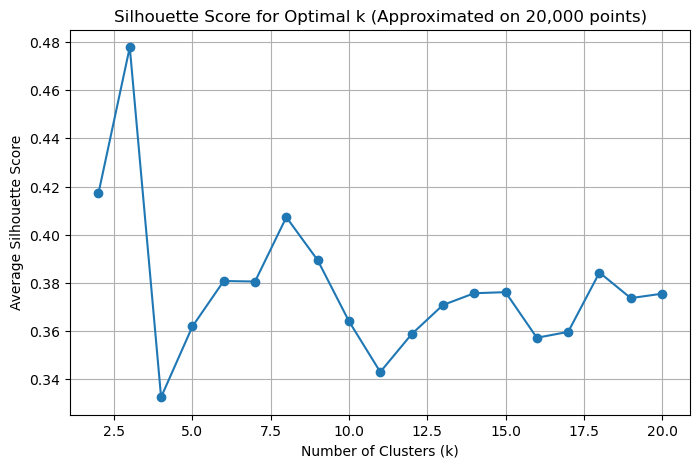

Best k according to silhouette score: 3 (score: 0.4779)


In [89]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed

X = gdf_pt_scaled 

# Define range of k values (start from 2)
k_range = range(2, 21)

# Function to compute silhouette for one k (with subsampling for speed)
def compute_silhouette(k, X, sample_size=10000, random_state=42):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X) 
    
    # Use sample_size for fast, reliable approximation
    score = silhouette_score(X, labels, sample_size=sample_size, random_state=random_state)
    return score

# Parallel computation across all k values (uses all CPU cores)
sil_scores = Parallel(n_jobs=-1)(
    delayed(compute_silhouette)(k, X) for k in k_range
)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, sil_scores, marker='o', linestyle='-')
plt.title('Silhouette Score for Optimal k (Approximated on 20,000 points)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.show()

# Print best k
best_k = k_range[np.argmax(sil_scores)]
print(f"Best k according to silhouette score: {best_k} (score: {max(sil_scores):.4f})")

➡️ According to the Silhouette plot, the optimum **K** value is 3.

#### **#3 Method:** Calinski-Harabasz Index

**Higher** values indicate denser, better-separated clusters.

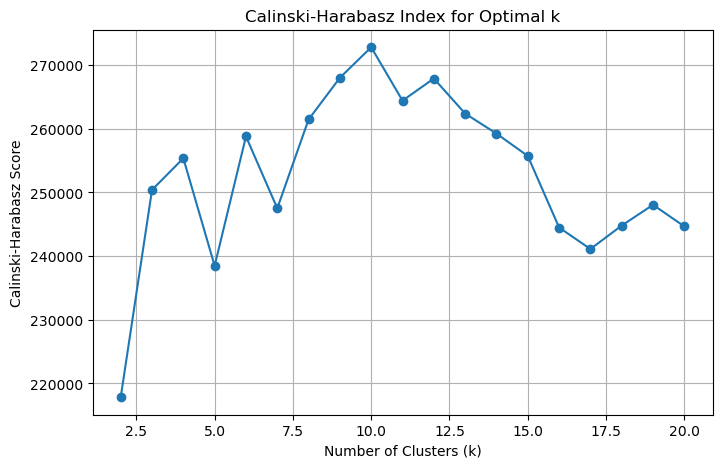

In [86]:
from sklearn.metrics import calinski_harabasz_score

# Define range of k values (start from 2)
k_range = range(2, 21)

# Compute Calinski-Harabasz scores
ch_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(gdf_pt_scaled)
    labels = kmeans.labels_
    score = calinski_harabasz_score(gdf_pt_scaled, labels)  # Compute CH score
    ch_scores.append(score)

# Plot the scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, ch_scores, marker='o')
plt.title('Calinski-Harabasz Index for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)
plt.show()

➡️ According to the Calinski-Harabasz plot, the optimum **K** value is **10**.

#### **#4 Method:** Davies-Bouldin Index

**Lower** values mean better separation and compactness.

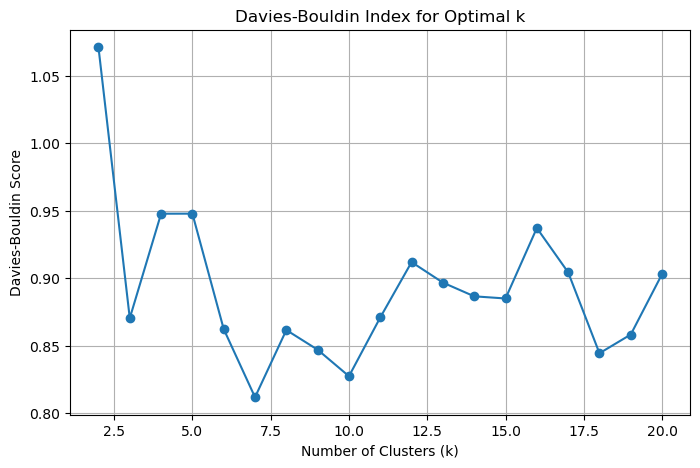

In [87]:
from sklearn.metrics import davies_bouldin_score

# Define range of k values (start from 2)
k_range = range(2, 21)

# Compute Davies-Bouldin scores
db_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(gdf_pt_scaled)
    labels = kmeans.labels_
    score = davies_bouldin_score(gdf_pt_scaled, labels)  # Compute DB score
    db_scores.append(score)

# Plot the scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True)
plt.show()

➡️ According to the Davies-Bouldin plot, the optimum **K** value is **7**.

#### **Find Best K for Power Transformed Data**

#### **#1 Method:**  Elbow method (with WSS, also called Inertia)

**Lower** value of WSS indicates better clustering.

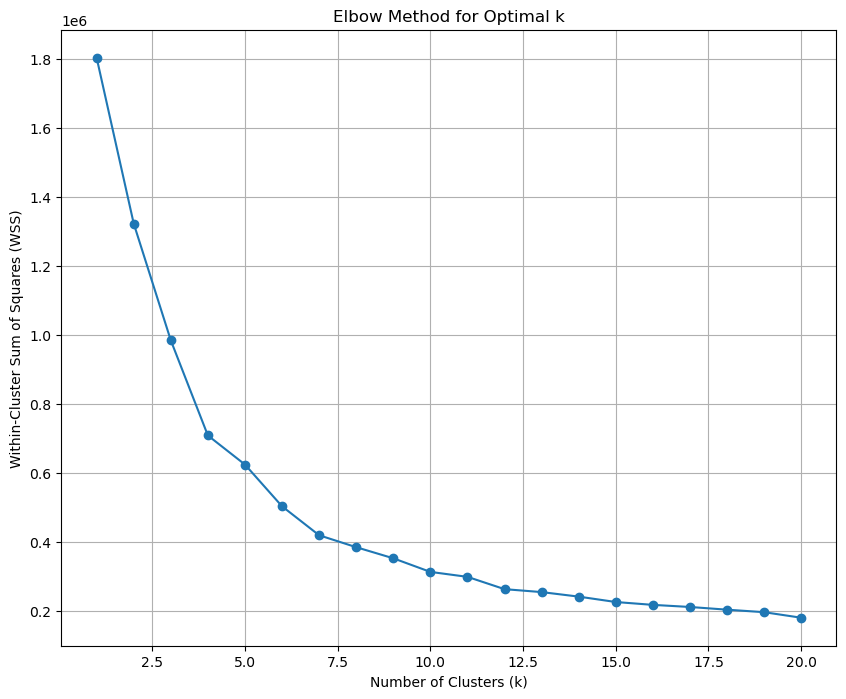

In [90]:
# Defne range of k values
k_range = range(1, 21)

# Compute inertia (WSS) for each k
wss = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(gdf_log_scaled)
    wss.append(kmeans.inertia_)

# Plot the Elbow curve
plt.figure(figsize=(10, 8))
plt.plot(k_range, wss, marker='o')  # Plot k vs. WSS with markers
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.grid(True)
plt.show()

➡️ From the plot, it seems `7` or `10` might be the optimal value for **K** (number of clusters). 

☑️ For more ensurance, we also plot the **Silhouette Score**, **Davies-Bouldin Index**, and **Calinski-Harabasz Index**.

#### **#2 Method:** Silhouette Score

The **higher** it is, the more separated the clusters are.

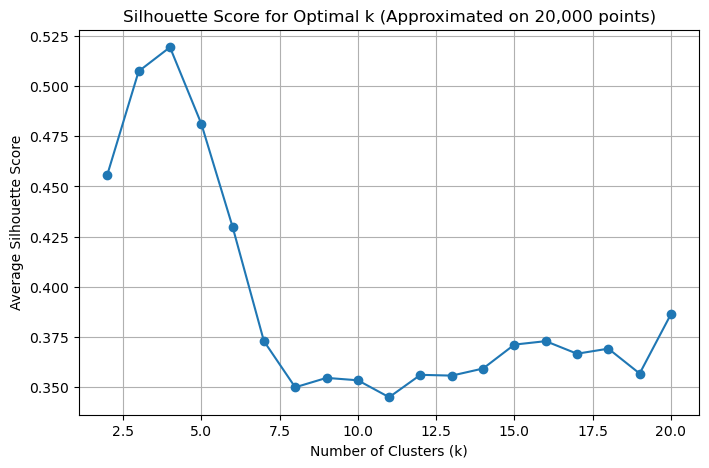

Best k according to silhouette score: 4 (score: 0.5194)


In [91]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from joblib import Parallel, delayed

X = gdf_log_scaled 

# Define range of k values (start from 2)
k_range = range(2, 21)

# Function to compute silhouette for one k (with subsampling for speed)
def compute_silhouette(k, X, sample_size=10000, random_state=42):
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X)  # fit and get labels
    
    # Use sample_size for fast, reliable approximation
    score = silhouette_score(X, labels, sample_size=sample_size, random_state=random_state)
    return score

# Parallel computation across all k values (uses all CPU cores)
sil_scores = Parallel(n_jobs=-1)(
    delayed(compute_silhouette)(k, X) for k in k_range
)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(k_range, sil_scores, marker='o', linestyle='-')
plt.title('Silhouette Score for Optimal k (Approximated on 20,000 points)')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.grid(True)
plt.show()

# Print best k
best_k = k_range[np.argmax(sil_scores)]
print(f"Best k according to silhouette score: {best_k} (score: {max(sil_scores):.4f})")

➡️ According to the Silhouette plot, the optimum **K** value is 4.

#### **#3 Method:** Calinski-Harabasz Index

**Higher** values indicate denser, better-separated clusters.

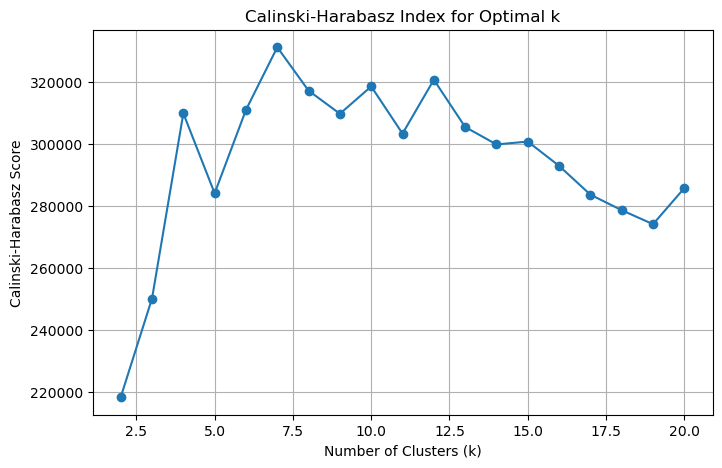

In [ ]:
from sklearn.metrics import calinski_harabasz_score

# Define range of k values (start from 2)
k_range = range(2, 21)

# Compute Calinski-Harabasz scores
ch_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(gdf_log_scaled)
    labels = kmeans.labels_
    score = calinski_harabasz_score(gdf_log_scaled, labels)  # Compute CH score
    ch_scores.append(score)

# Plot the scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, ch_scores, marker='o')
plt.title('Calinski-Harabasz Index for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Calinski-Harabasz Score')
plt.grid(True)
plt.show()

➡️ According to the Calinski-Harabasz plot, the optimum **K** value is **7**.

#### **#4 Method:** Davies-Bouldin Index

**Lower** values mean better separation and compactness.

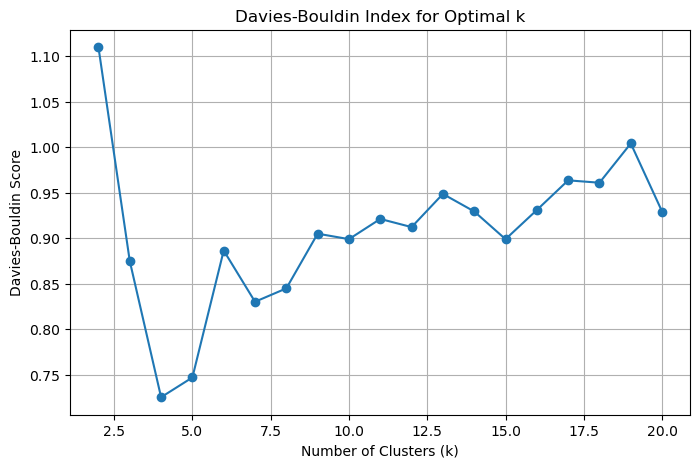

In [ ]:
from sklearn.metrics import davies_bouldin_score

# Define range of k values (start from 2)
k_range = range(2, 21)

# Compute Davies-Bouldin scores
db_scores = []
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(gdf_log_scaled)
    labels = kmeans.labels_
    score = davies_bouldin_score(gdf_log_scaled, labels)  # Compute DB score
    db_scores.append(score)

# Plot the scores
plt.figure(figsize=(8, 5))
plt.plot(k_range, db_scores, marker='o')
plt.title('Davies-Bouldin Index for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Davies-Bouldin Score')
plt.grid(True)
plt.show()

➡️ According to the Davies-Bouldin plot, the optimum **K** value is **4**.

#### **Conclusion:**
Overally,<br>
- For **power transformed** data, metrics respectively found: 10 or 7, 3, 10, and 7 -> So 7 must be the optimal value

- For **log transformed** data, metrics respectively found: 10 or 7, 4, 7, and 4 -> So both 7 & 4 are optimal values


In [92]:
# Delete unnecessary variables
del gdf, db_scores, ch_scores, sil_scores, gdf_log, gdf_log_scaled
del centers_lat, centers_lon, gdf_pt, k_range, kmeans, labels, score, wss

---

## **Part 3** <br>
Clustering Using DBSCAN Algorithm.

### **Preprocessing**

**↪Features to select:** `location_latitude`, `location_longitude`, `price_value`, `rent_value`, and `credit_value`

In [93]:
part_3_data = data[['location_latitude', 'location_longitude', 'price_value', 'rent_value', 'credit_value']]

In [94]:
# Fill price_value missing values with transformed_price based on rent_value and credit_value
def rent_to_price(rent, credit):
    """
    Convert rent to price
    """
    if rent < 0 or credit < 0:
        return 0
    credit_total = credit + (rent * 100) / 3
    transformed_price = credit_total * 6
    return max(0, transformed_price)

# Transform price value
part_3_data.loc[:, 'price_value'] = part_3_data.apply(
    lambda row: rent_to_price(row['rent_value'], row['credit_value']) if
      (pd.isna(row['price_value']) & pd.notna(row['rent_value']) & pd.notna(row['credit_value'])) else row['price_value'],
       axis=1)

# Drop unnessary features
part_3_data = part_3_data.drop(columns=['rent_value', 'credit_value'], axis=1)

# Handling missing values
part_3_data = part_3_data.dropna()

Remove data points out of **Iran's borders** using **GeoPandas**:

In [95]:
# Get only datapoints within Iran's borders
import geopandas as gpd

# Build GeoDataFrame in WGS84
gdf = gpd.GeoDataFrame(
    part_3_data,
    geometry=gpd.points_from_xy(
        part_3_data["location_longitude"],
        part_3_data["location_latitude"]
    ),
    crs="EPSG:4326"
)

# Load Iran border (Natural Earth)
iran = gpd.read_file(
    "https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_countries.zip"
)
iran = iran[iran["NAME"] == "Iran"].to_crs("EPSG:4326")

# Spatial filter
iran_geom = iran.geometry.iloc[0]
gdf = gdf[gdf.within(iran_geom)].copy()


Convert geographical coordinates to UTM format:

In [96]:
# Find and add Iran's UTM zones
gdf['utm_zone'] = (np.floor((gdf['location_longitude'] + 180) / 6) + 1).astype(int)
print("Zones are: ", gdf['utm_zone'].unique())

Zones are:  [39 40 38 41]


In [97]:
# Adding UTM cordinations to the data points
def apply_utm_conversion(group):
    zone = group.name
    wgs84_crs = CRS.from_epsg(4326)
    utm_crs = CRS.from_epsg(32600 + zone)
    transformer = Transformer.from_crs(wgs84_crs, utm_crs, always_xy=True)
    
    easting, northing = transformer.transform(
        group['location_longitude'].values,
        group['location_latitude'].values
    )
    
    group['utm_easting'] = easting
    group['utm_northing'] = northing
    return group

gdf = gdf.groupby(['utm_zone'], group_keys=False).apply(apply_utm_conversion, include_groups=False)
gdf.head()

location_latitude  location_longitude   price_value  \
2           35.703865           51.373459  9.700000e+09   
7           35.729832           51.505466  8.700000e+09   
8           35.712364           50.794781  6.500000e+08   
10          35.778664           51.757549  2.600000e+09   
11          35.733952           51.380608  7.200000e+09   

                     geometry    utm_easting  utm_northing  
2   POINT (51.37346 35.70387)  533784.424602  3.951168e+06  
7   POINT (51.50547 35.72983)  545711.558185  3.954101e+06  
8   POINT (50.79478 35.71236)  481437.130969  3.952066e+06  
10  POINT (51.75755 35.77866)  568467.028494  3.959664e+06  
11  POINT (51.38061 35.73395)  534418.187237  3.954507e+06

#### **Take Smaller Sample From Data** <br>
Since there are many samples (600 thousands), we take a smaller sample of 100 thousand size to be able to perform our algorithms.

In [98]:
sample_size = 100000
sampled_data = gdf.sample(sample_size, random_state=42)
sampled_data.shape

(100000, 6)

#### **Outlier Handling**

See variables distributions:

In [ ]:
sampled_data.hist(figsize=(10, 8), bins=30, edgecolor='black')

Remove Noise:

In [100]:
# Remove rows where price_value is 0
sampled_data = sampled_data[sampled_data['price_value'] != 0]

Apply Log Transformation:

In [101]:
# Apply log transformation
sampled_data['price_value'] = np.log(sampled_data['price_value'])

#### **Feature Scaling**

Feature Scaling to have better clustering using K-means.

In [102]:
# Feature Scaling on the Features : utm_easting , utm_northing, price_value
scalar = StandardScaler()
sampled_data_scaled = scalar.fit_transform(sampled_data[['location_latitude', 'location_longitude', 'price_value']])
sampled_data_scaled = pd.DataFrame(sampled_data_scaled, columns=['location_latitude', 'location_longitude', 'price_value'])

#### **Train DBSCAN on Intuitively Chosen Hyperparameters**<br>

In [103]:
from sklearn.cluster import DBSCAN

# Create a DBSCAN model
esp, min_samples = 0.5, 650
dbscan = DBSCAN(eps=esp, min_samples=min_samples, n_jobs=-1)

sampled_data['cluster_number'] = dbscan.fit_predict(sampled_data_scaled)

In [104]:
sampled_data['cluster_number'].value_counts()

cluster_number
 0    85203
 1     7441
-1     6012
 2     1138
Name: count, dtype: int64

#### **Plot The Map**

In [ ]:
# Force cluster_number to be categorical by converting it to string
sampled_data["cluster_number"] = sampled_data["cluster_number"].astype(str)

# Define a cluster color palette
cluster_colors = {
    0: "#264653",  # deep blue-gray
    1: "#005F73",  # dark teal
    2: "#9B2226",  # dark green
    "-1": "black"
}

# Separate regular clusters and noise
clusters_data = sampled_data[sampled_data["cluster_number"] != "-1"]
noise_data = sampled_data[sampled_data["cluster_number"] == "-1"]

fig = px.scatter_map(
    clusters_data, 
    lat='location_latitude', 
    lon='location_longitude', 
    color='cluster_number',
    color_discrete_map=cluster_colors,
    hover_data=['price_value', 'utm_easting', 'utm_northing'],
    map_style="open-street-map",
    zoom=3.75, 
    center={"lat": 32.4279, "lon": 53.6880},
    title=f'Map of the samples with DBSCAN Clusters (3 Cluster) and Noise | esp={esp}, min_samples={min_samples}',
    width=1550,
    height=800,
)

# Add noise points as a separate trace (black)
if len(noise_data) > 0:
    fig.add_scattermap(
        lat=noise_data["location_latitude"],
        lon=noise_data["location_longitude"],
        mode="markers",
        marker=dict(size=6, color="black", opacity=0.6, symbol="cross"),
        name="Noise (-1)"
    )

fig.show()

In [106]:
# Delete unnessary variables
del sampled_data, sampled_data_scaled, esp, min_samples
del clusters_data, noise_data, cluster_colors, dbscan, gdf, part_3_data

↪ With `epp` of **0.5** and `min_smples` of **650**, the plot results these 3 dense and well separated clusters.<br>

Most of the properties from the sample cluster 0 which covers **north**, **center** and **west** of Iran. Cluster 1 covers the **north-west** region (Khorasan Razavi),<br>

and the third cluster (cluster 2) includes properties from **Kerman** province. It seems that they might have different prices from other regions in Iran.

The noises are marked as `X`.

#### **DBSCAN Hyperparameters (eps & min_samples) intuation**

**eps (maximum neighbor distance):** Controls the spatial reach of density
<br>

- ⬇ **Smaller eps:** Points must be very close to be connected → results in **more clusters**, more fragmented data, and often more **noise points**.

- ⬆ **Larger eps:** Points can be farther apart and still connect → results in **fewer clusters** (merging distant groups), potentially one large cluster, and **less noise**.

**min_samples (minimum points for a core point):** Controls how dense a region must be to qualify as a cluster
<br>

- ⬇ **Smaller eps:** Easier to form core points → **larger/more clusters**, **less noise**, more tolerant of sparser regions (can create small or chained clusters).

- ⬆ **Larger eps:** Requires **higher density** to form core points → **fewer clusters**, **more noise**, ignores low-density areas (clusters are denser and more robust).

*↪ Following, we can show you what happend on the map whe we lower and raise the eps or the min_samples hyperparameters:*

When increase eps (esp=0.6, min_samples=650):

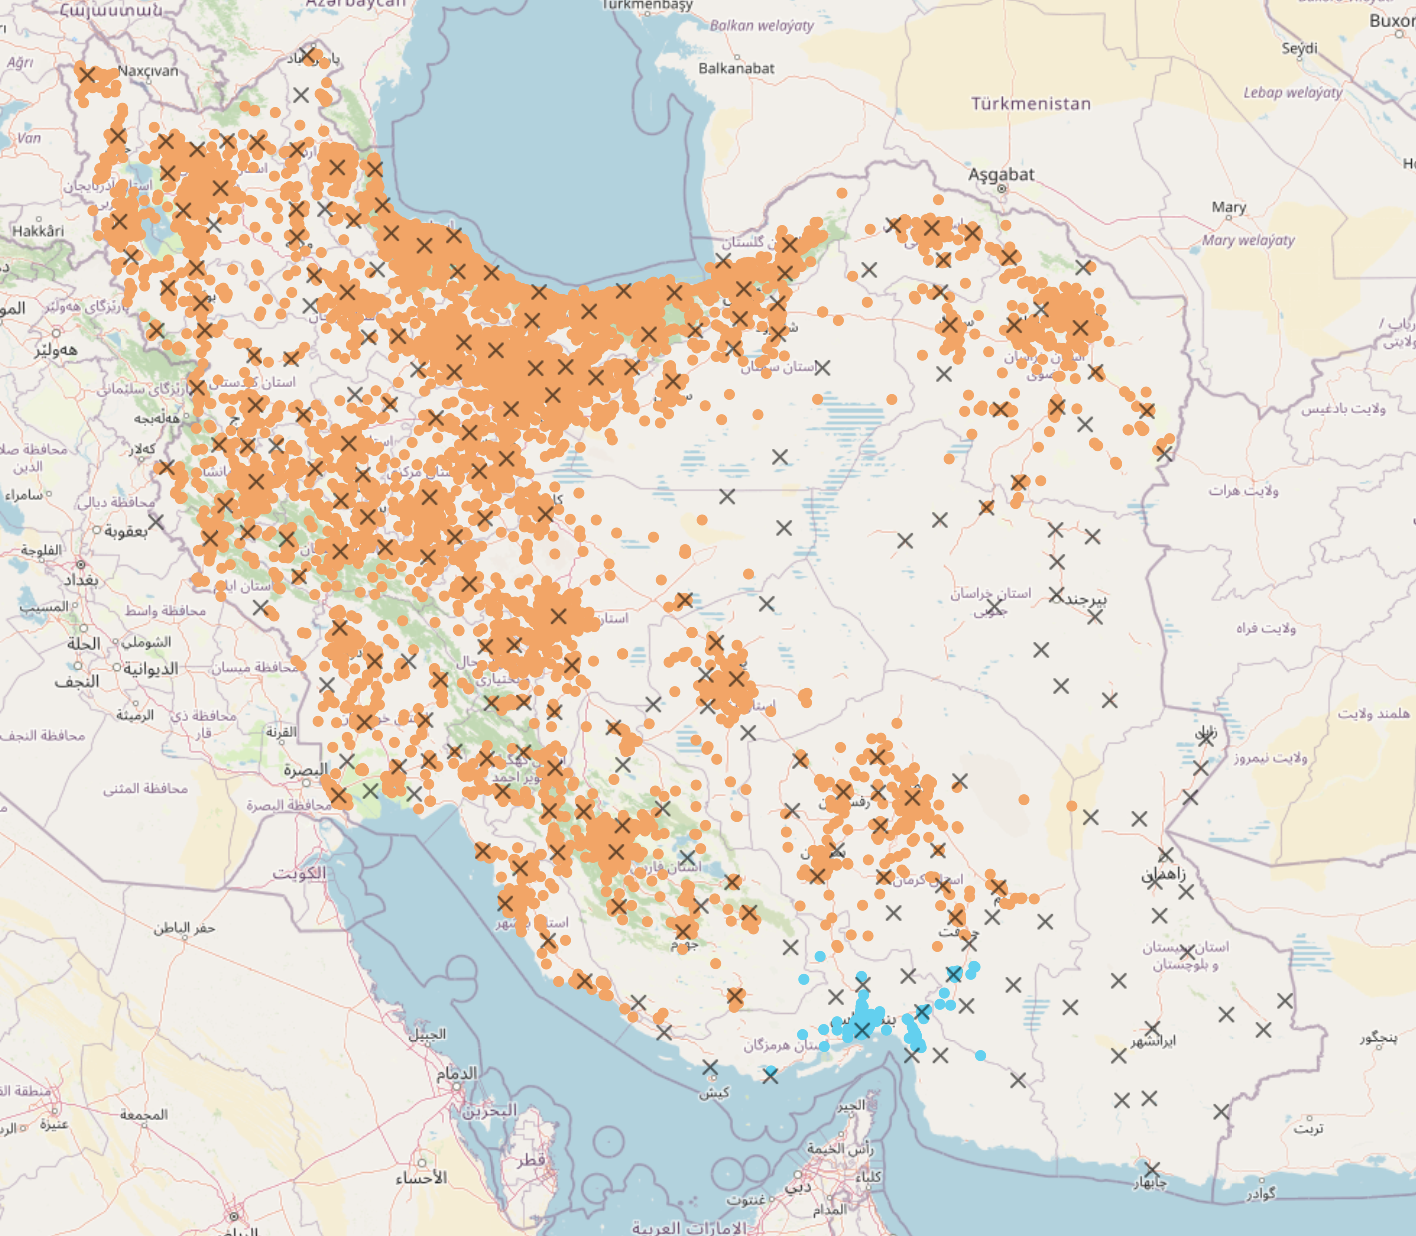

When decrease eps (esp=0.3, min_samples=4000):

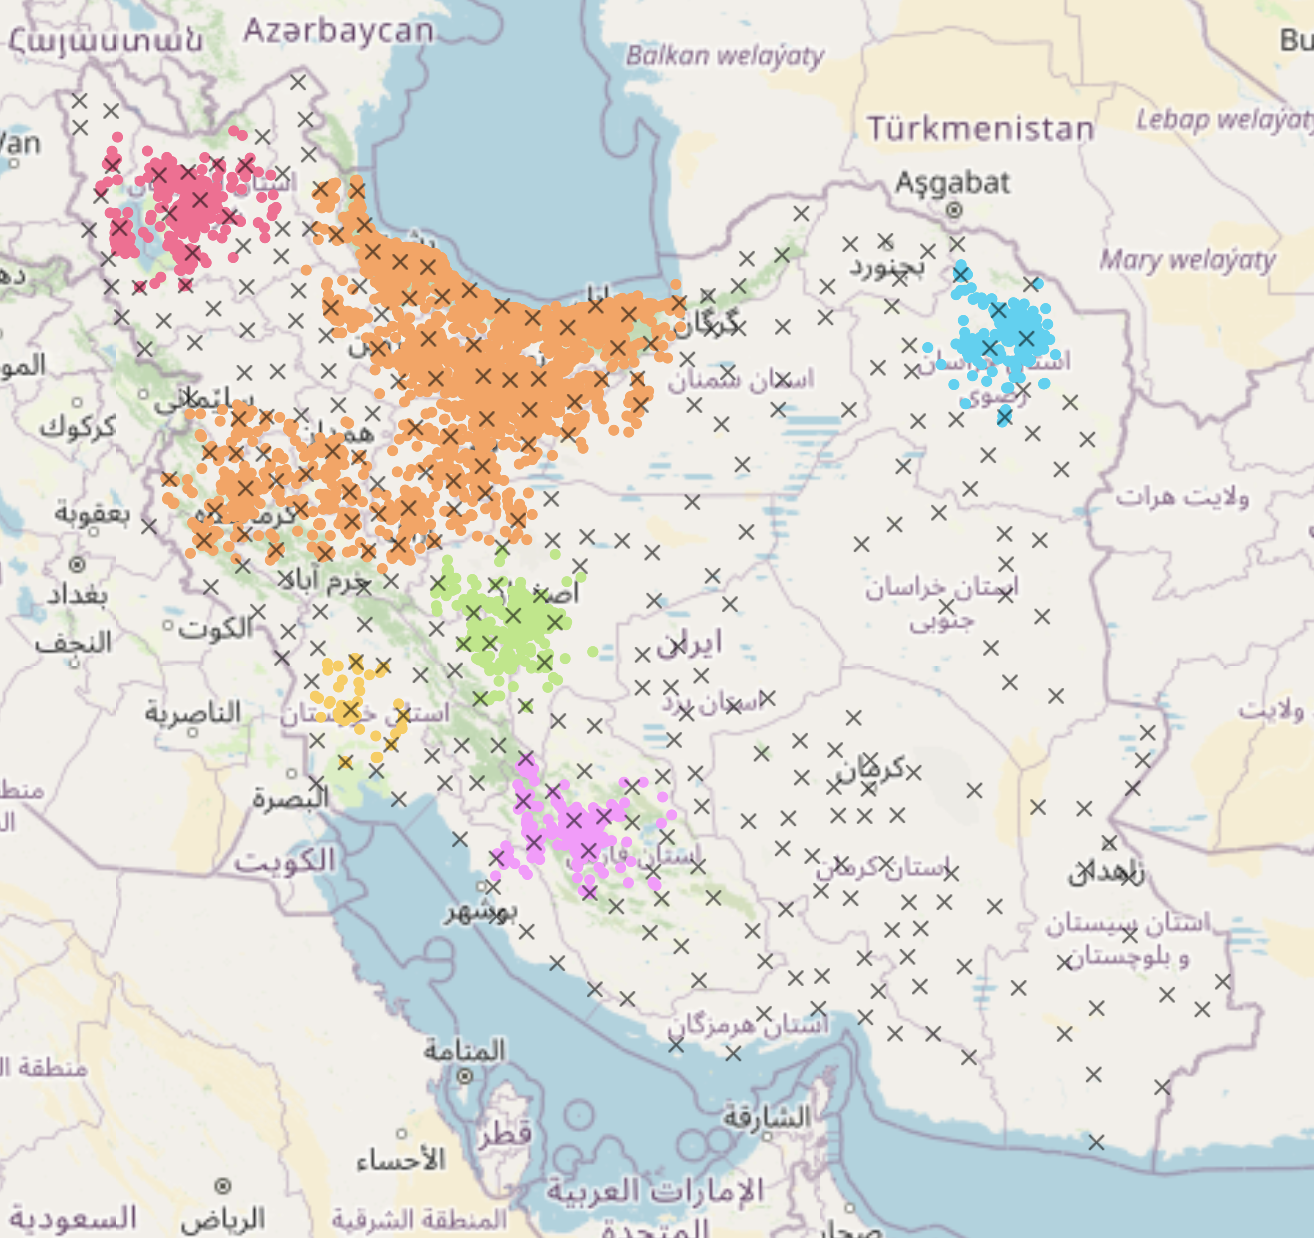

When increase min_samples (esp=0.5, min_samples=4000):

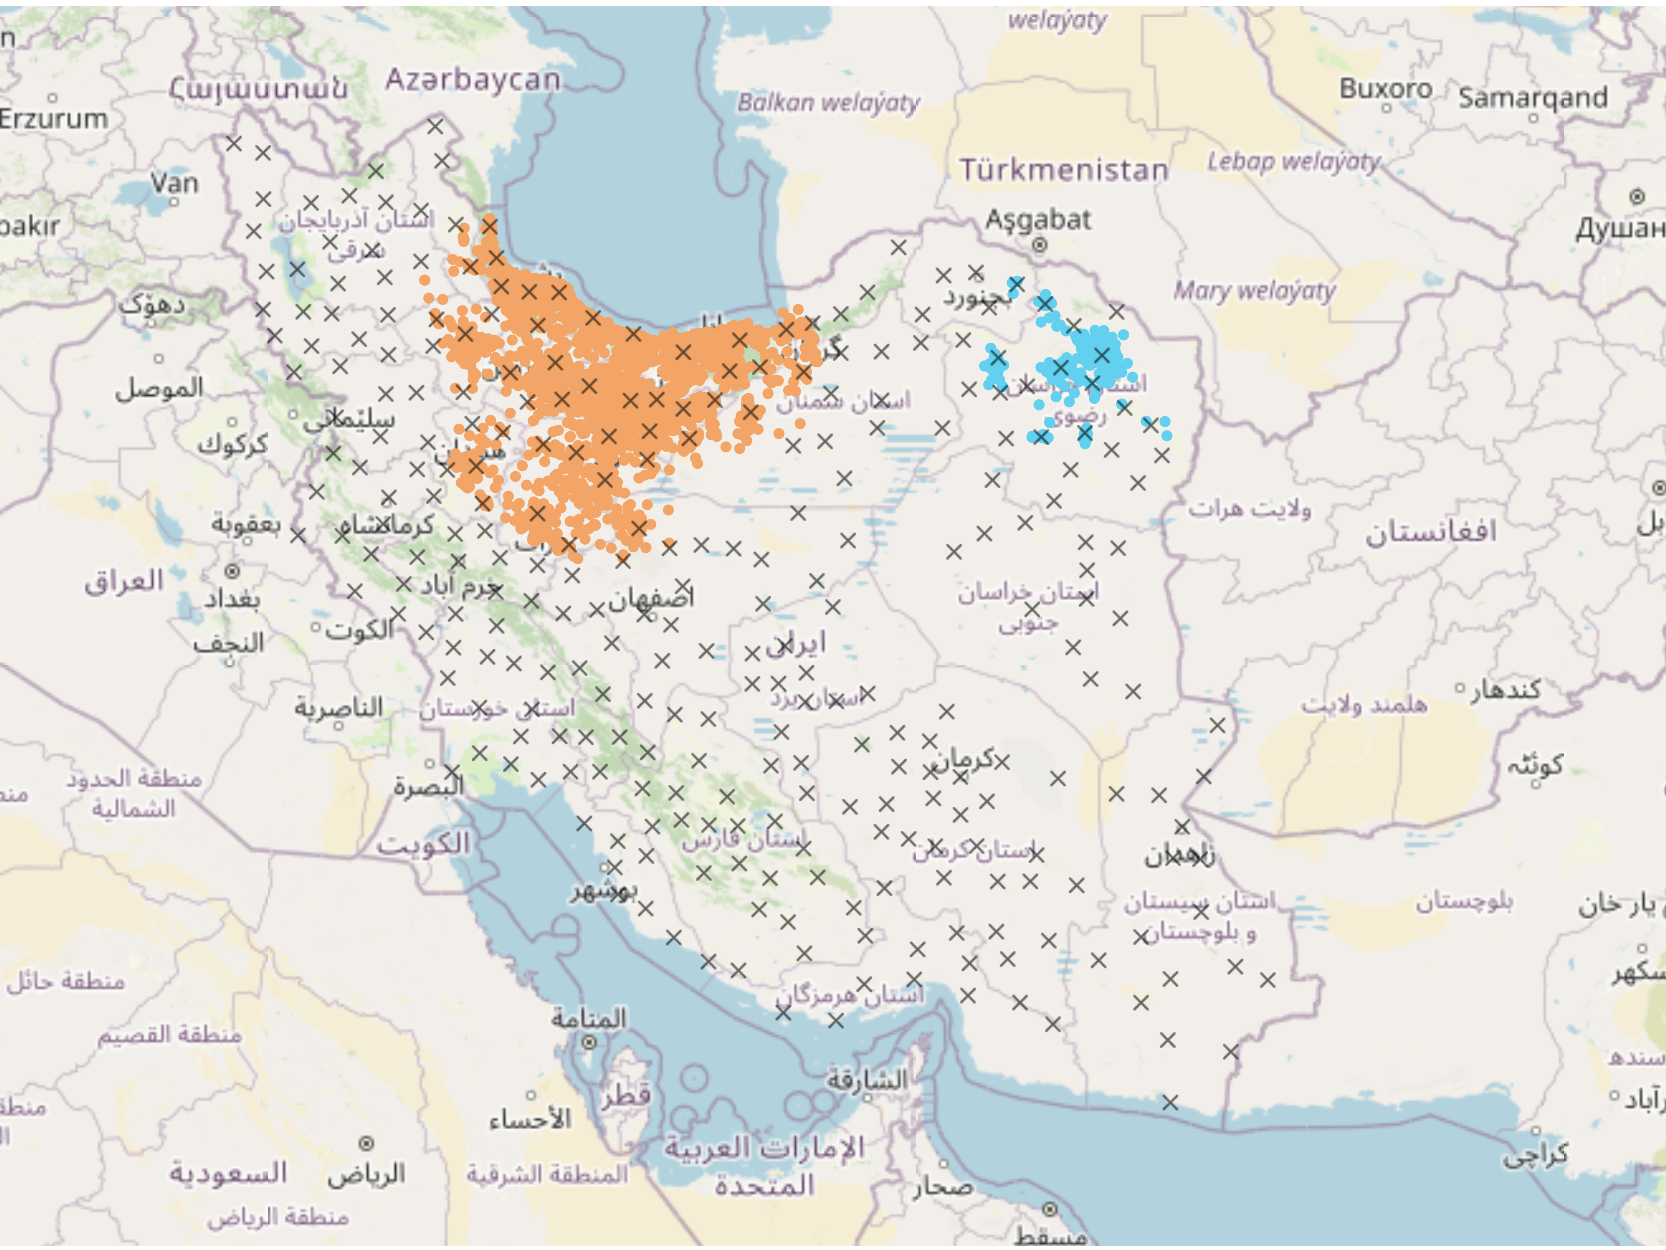

When decrease min_samples (esp=0.5, min_samples=50):

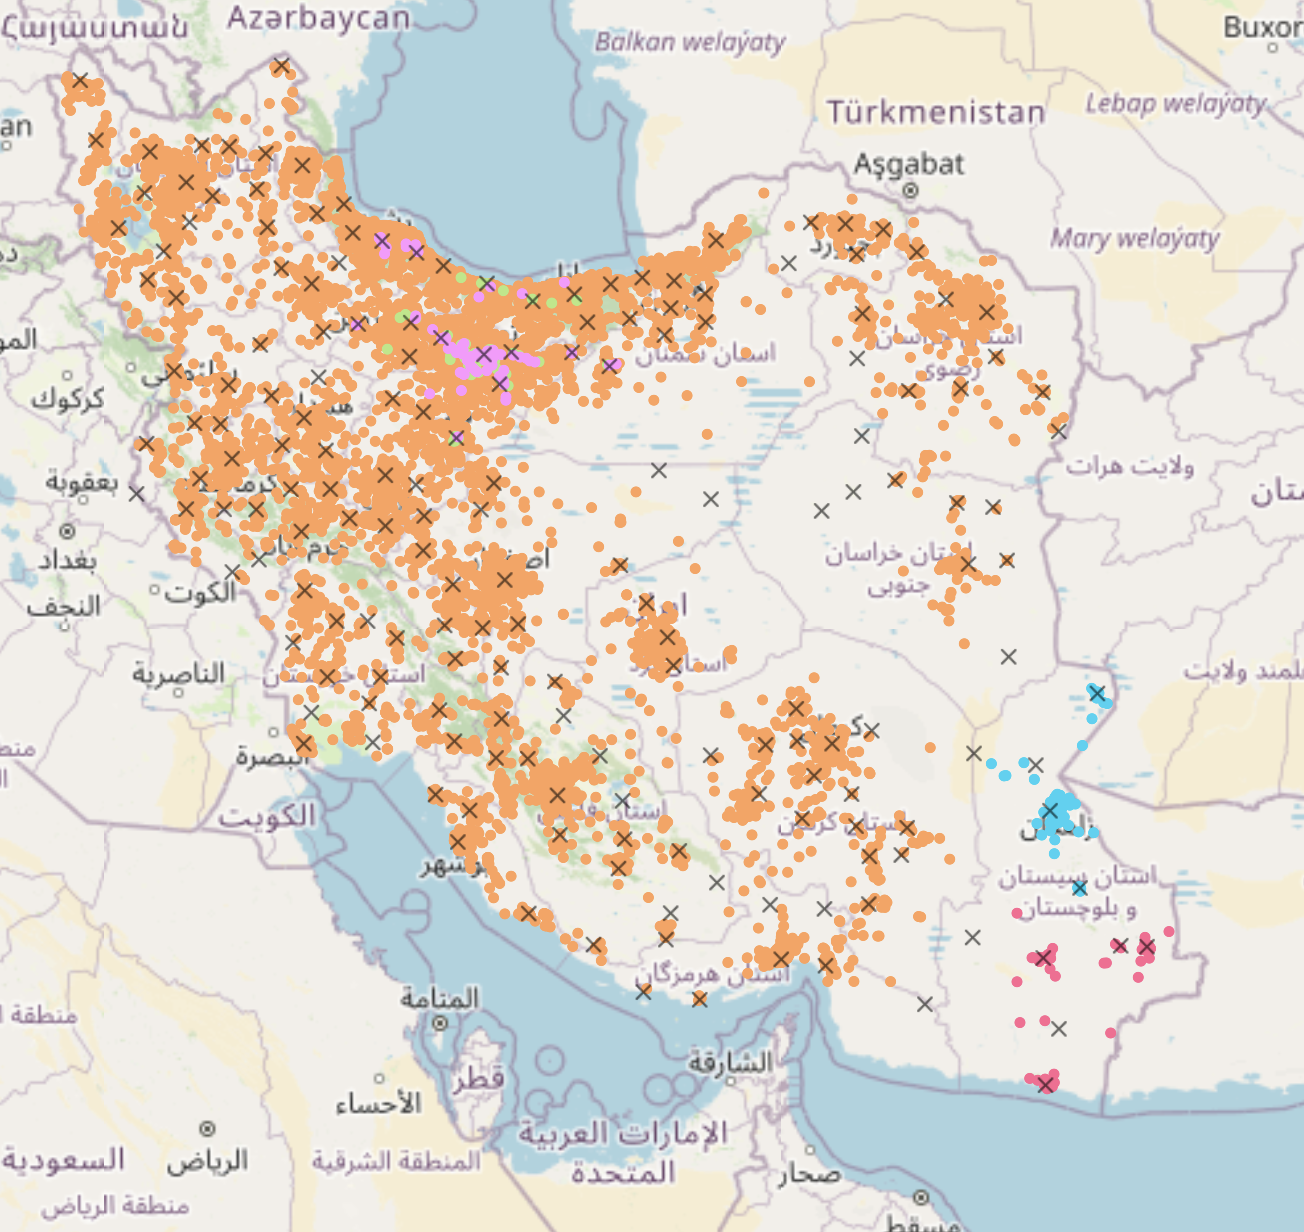